In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import tqdm
import pickle
import matplotlib.pyplot as plt
from Bio.PDB import *
from rdkit import Chem
import os
import time
import shutil
from Bio.SeqUtils import seq1
import gzip
import tarfile
import sys
import random

In [2]:
def good_ligand(inchi):
    try:
        m = Chem.MolFromInchi(inchi)
        count_carbons = 0
        for i in m.GetAtoms():
            if int(i.GetAtomicNum()) == 6:
                count_carbons += 1
            if count_carbons >= 7:
                break
        return count_carbons >= 7
    except:
        return False
    

# Natural amino acids
nat_aa = {'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'}
maestro_blacklist = set([i.strip() for i in pd.read_csv("/aloy/home/acomajuncosa/PocketVec_v2/kinase/PDB/LIG/preprocess/maestro_blacklist.csv")[' Residue']])
# uninteresting_ligands = pickle.load(open("/aloy/home/acomajuncosa/Apps_PocketVec/HT/PDB/uninteresting_ligands.pkl", "rb")) ## Not using it, for the moment
original_wd = os.getcwd()

In [4]:
### GET INTERESTING LIGANDS

###../data/PDB and LIGAND_PDB mapping --> https://www.ebi.ac.uk/thornton-srv/databases/pdbsum/data/lig_pairs.lst
###  2. PDB and HET_PDB mapping --> https://www.ebi.ac.uk/thornton-srv/databases/pdbsum/data/het_pairs.lst
###  3. Mapping 3-letter PDB code with inchi --> http://ligand-expo.rcsb.org/ld-download.html

pdbcode_to_inchi = pd.read_csv("../data/PDB/mapping/Components-inchi.ich.txt", sep="\t", header=None, names=['inchi', 'PDB', 'name'], usecols=[0,1])  
# From df to dict's  // PDB-LIGs
d = {}
for i,j in zip(pdbcode_to_inchi['inchi'], pdbcode_to_inchi['PDB']):
    if str(j) == 'nan': j = "NA"
    d[str(j)] = i
pdbcode_to_inchi = d; del d

interesting_ligands = set()

for lig in tqdm.tqdm(sorted(pdbcode_to_inchi)):
    inchi = pdbcode_to_inchi[lig]
    if "-" not in lig and lig not in maestro_blacklist and lig not in nat_aa and good_ligand(inchi) is True:
        interesting_ligands.add(lig)

  3%|▎         | 1051/37360 [00:00<00:21, 1663.38it/s]RDKit ERROR: [17:05:05] ERROR: Explicit valence for atom # 27 Be, 4, is greater than permitted
RDKit ERROR: [17:05:05] Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [17:05:05] ERROR: Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [17:05:05] Explicit valence for atom # 15 C, 6, is greater than permitted
  4%|▍         | 1404/37360 [00:00<00:21, 1682.11it/s]RDKit ERROR: [17:05:05] ERROR: Explicit valence for atom # 15 C, 6, is greater than permitted
RDKit ERROR: [17:05:05] Explicit valence for atom # 16 N, 5, is greater than permitted
  5%|▍         | 1739/37360 [00:01<00:21, 1648.97it/s]RDKit ERROR: [17:05:05] ERROR: Explicit valence for atom # 16 N, 5, is greater than permitted
RDKit ERROR: [17:05:06] Explicit valence for atom # 0 C, 5, is greater than permitted
  6%|▋         | 2426/37360 [00:01<00:20, 1681.91it/s]RDKit ERROR: [17:05:06] ERROR: Explicit valence for atom # 0

In [5]:
### FIND INTERESTING PDBS

pdbs_intlig = {}  # Interesting ligands
pdbs_lig = {}  # Non interesting ligands
pdbs_het = {}  # Other (e.g. non std residues)

with open("../data/PDB/mapping/lig_pairs.lst.txt", "r") as f:
    for l in f:
        pdb = l.split(":")[0].strip()
        ligs = [i.strip().strip("_") for i in l.split(":")[1].split(";")[:-1]]
        intligs = [i for i in ligs if i in interesting_ligands]
        ligs = [j for i in ligs for j in i.split("-") if j not in intligs]
        if len(ligs) > 0:
            pdbs_lig[pdb] = ligs
        if len(intligs) > 0:
            pdbs_intlig[pdb] = intligs
            
with open("../data/PDB/mapping/het_pairs.lst.txt", "r") as f:
    for l in f:
        pdb = l.split(":")[0].strip()
        hets = [i.strip() for i in l.split(":")[1].split(";")[:-1]]
        if len(hets) > 0:
            pdbs_het[pdb] = hets
            
ligands = [j for i in sorted(pdbs_intlig) for j in pdbs_intlig[i]]

In [6]:
### PREPARE THE DATAFRAME

In [7]:
# File obtained from https://ftp.ebi.ac.uk/pub/databases/pdb/derived_data/pdb_entry_type.txt
pdb_to_entrytype = pd.read_csv("../data/PDB/mapping/pdb_entry_type.txt", sep="\t", header=None, names=['PDB', 'type', 'method'])
pdb_to_entrytype = {i: j for i,j in zip(pdb_to_entrytype['PDB'], pdb_to_entrytype['type'])}

In [8]:
data = []

for pdb in sorted(pdbs_intlig):
    # Interesting ligands
    for intlig in pdbs_intlig[pdb]:
        # Non interesting ligands
        try:
            lig = ",".join(pdbs_lig[pdb])
            if len(lig) == 0:
                lig = np.nan
        except:
            lig = np.nan
        # Hetatms
        try:
            het = pdbs_het[pdb]
            het = [i for i in het if i not in pdbs_intlig[pdb]]
            if pdb in pdbs_lig:
                het = [i for i in het if i not in pdbs_lig[pdb]]
            if len(het) == 0:
                het = np.nan
            else:
                het = ",".join(het)
        except:
            het = np.nan
            
        if pdb in pdb_to_entrytype:
            data.append([pdb.upper(), intlig, lig, het, pdb_to_entrytype[pdb]])
        else:
            data.append([pdb.upper(), intlig, lig, het, 'Undefined'])
    
data = pd.DataFrame(data, columns=['PDB', 'INT_LIG', 'LIG', 'HET', 'type'])
data = data.loc[data['type'] == 'prot'].reset_index()
del data['index']

In [9]:
data

,PDB,INT_LIG,LIG,HET,type
0,10GS,VWW,MES,NaN,prot
1,11BA,UPA,SO4,NaN,prot
2,11BG,U2G,SO4,NaN,prot
3,121P,GCP,MG,NaN,prot
4,12AS,AMP,ASN,NaN,prot
...,...,...,...,...,...
86105,9LDB,NAD,"SO4,OXM",ACE,prot
86106,9LDT,NAD,"SO4,OXM",ACE,prot
86107,9NSE,H4B,"ACT,HEM,ISU,CAD,GOL,ZN",NaN,prot
86108,9RSA,ADU,NaN,NaN,prot


In [10]:
print("Number of PDBs: " + str(len(set(data['PDB']))))
print("Number of ligands: " + str(len(data['INT_LIG'])))
print("Number of ligands [unique]: " + str(len(set(data['INT_LIG']))))

Number of PDBs: 67582
Number of ligands: 86110
Number of ligands [unique]: 28937


In [11]:
count_ligands = Counter(ligands)
sorted_ligands = sorted(count_ligands, key=lambda x: count_ligands[x])[::-1]
top = 20
a = np.sum([count_ligands[i] for i in sorted_ligands[:top]])
b = np.sum([count_ligands[i] for i in sorted_ligands])

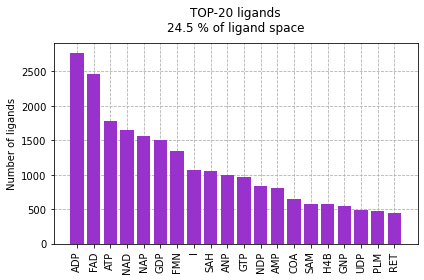

In [12]:
%matplotlib inline
plt.figure(figsize=(6, 4))
plt.grid(linestyle='--', zorder=-2)

for c, i in enumerate(sorted_ligands[:top]):
    
    plt.bar([c], count_ligands[i], color='darkorchid', zorder=2)

plt.xticks([i for i in range(top)], [i for i in sorted_ligands[:top]], rotation=90)
plt.ylabel("Number of ligands")
plt.title("TOP-" + str(top) + " ligands\n" + str(round(a/b*100, 1)) + " % of ligand space", pad=12)
plt.tight_layout()
plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/top_" + str(top) + "_ligands_bar.png", dpi=300)
plt.show()

mols = [Chem.MolFromInchi(pdbcode_to_inchi[i]) for i in sorted_ligands[:top]]
labs = [i for i in sorted_ligands[:top]]

img=Chem.Draw.MolsToGridImage(mols,molsPerRow=5,subImgSize=(200,200),legends=labs)    
img.save('/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/top_' + str(top) + '_ligands.png')

In [69]:
data.loc[data['PDB'] == "1A3T"]

,PDB,INT_LIG,LIG,HET,type
41,1A3T,THP,CA,EFC,prot


In [14]:
task_id = 0 

path_to_summary = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/summary", "summary_" + str(task_id) + ".tsv")

In [15]:
pdb = "1A3T"
int_lig = 'THP'
lig = ['CA']
het = ['EFC']

path = os.path.join("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/structures", pdb + "_" + int_lig)
if os.path.exists(path) is False: os.makedirs(path)

In [16]:
os.chdir(os.path.join(path))

### 1. Create directory & download pdb structure
with gzip.open('/aloy/home/acomajuncosa/programs/localpdb/mirror/pdb/' + pdb[1:3].lower() + '/pdb' + pdb.lower() + '.ent.gz', 'rb') as f_in:
    with open(os.path.join(path, pdb + ".pdb"), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [17]:
ligands_to_remove = ['W']
ligands_to_remove.append("H_" + " "*(3-len(int_lig)) + int_lig)
ligands_to_remove.append("H_" + int_lig + " "*(3-len(int_lig)))
for l in lig:
    ligands_to_remove.append("H_" + " "*(3-len(l)) + l)
    ligands_to_remove.append("H_" + l + " "*(3-len(l)))
ligands_to_remove = set(ligands_to_remove)

In [20]:
# 2. Remove water molecules and ligands // but not non std residues!
parser = PDBParser()
path_in = os.path.join(path, pdb + ".pdb")
path_out = path
structure = parser.get_structure("st", path_in)

class remove_ligs(Select):
    def accept_residue(self, residue):
        if residue.get_id()[0] not in ligands_to_remove:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save(os.path.join(path, pdb + "_st.pdb"), remove_ligs())

# 3. Remove hydrogens
command = 'python /aloy/home/acomajuncosa/programs/structureChecking/bin/check_structure -i ' + os.path.join(path_out , pdb + '_st.pdb') + ' -o ' + os.path.join(path_out , pdb + '_hydrogens.pdb') + ' --force_save --non_interactive rem_hydrogen --remove Yes'
o = os.popen(command).read()
sys.stderr.write(o + "\n\n")
sys.stderr.flush()

# 4. Select occupancies
command = 'python /aloy/home/acomajuncosa/programs/structureChecking/bin/check_structure -i ' + os.path.join(path_out , pdb + '_hydrogens.pdb') + ' -o ' + os.path.join(path_out , pdb + '_altloc.pdb') + ' --force_save --non_interactive altloc --select occupancy'
o = os.popen(command).read()
sys.stderr.write(o + "\n\n")
sys.stderr.flush()

=                   BioBB structure checking utility v3.0.3                   =
=                 A. Hospital, P. Andrio, J.L. Gelpi 2018-20                  =

Structure /aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/structures/1A3T_THP/1A3T_st.pdb loaded
 Title: 
 Experimental method: unknown
 Resolution: 0.0 A

 Num. models: 1
 Num. chains: 1 (A: Protein)
 Num. residues:  135
 Num. residues with ins. codes:  0
 Num. HETATM residues:  1
 Num. ligands or modified residues:  1
 Num. water mol.:  0
 Num. atoms:  1348
Modified residues found
EFC A23

Running rem_hydrogen. Options: --remove Yes
128 Residues containing H atoms detected
Hydrogen atoms removed from 128 residues
Final Num. models: 1
Final Num. chains: 1 (A: Protein)
Final Num. residues:  135
Final Num. residues with ins. codes:  0
Final Num. HETATM residues:  1
Final Num. ligands or modified residues:  1
Final Num. water mol.:  0
Final Num. atoms:  1085
Modified residues found
EFC A23
Structure saved on /aloy/home

In [ ]:
def get_centroid(infile, outfile):
    # Save centroid
    res = [i for i in pdb_structure.get_residues() if i == ligand][0]
    ligatoms = [at.coord for at in res.get_atoms()]
    x = np.mean(np.array(ligatoms)[:,0])
    y = np.mean(np.array(ligatoms)[:,1])
    z = np.mean(np.array(ligatoms)[:,2])
    center = np.array([x, y, z], dtype=np.float32)

    x, y, z = str(round(x, 3)), str(round(y, 3)), str(round(z, 3))
    ctr = " "*(8-len(x)) + x + " "*(8-len(y)) + y + " "*(8-len(z)) + z
    text = """HEADER\nHETATM    1   C  CTR A   1    """ + ctr + """  1.00  1.00           C\nEND"""

    with open(os.path.join(path, label, intlig + "_CTR_" + str(count) + ".pdb"), "w") as f:
        f.write(text)

In [30]:
parser = PDBParser()
structure = parser.get_structure("st", os.path.join(path, pdb + ".pdb"))
interesting_ligands = [i for i in structure.get_residues() if i.get_resname() == int_lig]


for c, interesting_ligand in enumerate(interesting_ligands):
    
    # 5. Select ligand and save it separately
    class LigSelect(Select):
        def accept_residue(self, residue):
            if residue == interesting_ligand:
                return 1
            else:
                return 0
            
    io = PDBIO()
    io.set_structure(structure)
    io.save(os.path.join(path, int_lig + "_" + str(c) + ".pdb"), LigSelect())

In [ ]:
        #####################################
        #-----PARSING PDB & ACCESSIBILITY----
        #####################################


            ## 4. Select ligands and save them separately
            pdb_structure = parser.get_structure("st", os.path.join(path, label, pdb + ".pdb"))[0]  # Take only the first model. Trivial for X-ray, only 1st for NMR
            ligands = [i for i in pdb_structure.get_residues() if i.get_resname() == intlig]  # Repeated entities of the same ligand (e.g 'YDJ repeated twice')

            class LigSelect(Select):
                def accept_residue(self, residue):
                    if residue == ligand:
                        return 1
                    else:
                        return 0

            def SASA(prot, lig):
    
                # compute ligand SASA
                lig_h = Chem.AddHs(lig, addCoords=True)

                # Get Van der Waals radii (angstrom)
                ptable = Chem.GetPeriodicTable()
                radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in lig_h.GetAtoms()]

                # Compute solvent accessible surface area
                lig_sasa = rdFreeSASA.CalcSASA(lig_h, radii)
                
                # Join protein & ligand
                comp = Chem.CombineMols(prot, lig)
                comp_h = Chem.AddHs(comp, addCoords=True)

                # Get Van der Waals radii (angstrom)
                ptable = Chem.GetPeriodicTable()
                radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in comp_h.GetAtoms()]

                # Compute solvent accessible surface area
                comp_sasa = rdFreeSASA.CalcSASA(comp_h, radii)
                
                comp_lig = Chem.GetMolFrags(comp_h, asMols=True,  sanitizeFrags=True)
                comp_lig = [i for i in comp_lig if MolWt(i) == MolWt(lig_h)]
                # Avoid including smaller ligands than expected (e.g. 7PE in 5EHY)
                at = [i.GetAtomicNum() for i in lig.GetAtoms()]
                if len(comp_lig) != 1 or Counter(at)[6] < 5:
                    return np.nan, np.nan
                else:
                    comp_lig = comp_lig[0]

                lig_sasa_free = 0
                for a in lig_h.GetAtoms():
                    lig_sasa_free += float(a.GetProp("SASA"))

                lig_sasa_bound = 0
                for a in comp_lig.GetAtoms():
                    lig_sasa_bound += float(a.GetProp("SASA"))

                return round(lig_sasa_free, 3), round(lig_sasa_bound, 3)



            for count, ligand in enumerate(ligands):

                try:

                    # Save ligand
                    io = PDBIO()
                    io.set_structure(pdb_structure)
                    io.save(os.path.join(os.path.join(path, label, intlig + "_" + str(count) + ".pdb")), LigSelect())
                    #command = 'obabel ' + os.path.join(path, label, intlig + "_" + str(count) + ".pdb") + ' -O ' + os.path.join(path, label, intlig + "_" + str(count) + ".sdf")
                    #os.system(command)
                    #os.remove(os.path.join(path, label, intlig + "_" + str(count) + ".pdb"))

                    


                    # Get SASA
                    prot = Chem.MolFromPDBFile(os.path.join(path, label, label + ".pdb"))
                    lig = Chem.MolFromPDBFile(os.path.join(path, label, intlig + "_" + str(count) + ".pdb"))

                    lig_sasa_free, lig_sasa_bound = SASA(prot, lig)
                    acc = round(lig_sasa_bound/lig_sasa_free, 3)

                    outfile.write("\t".join([domain, pdb, chain, intlig, str(count), str(lig_sasa_free), str(lig_sasa_bound), str(acc)]) + "\n")

                except:

                    outfile.write("\t".join([domain, pdb, chain, intlig, str(count), str('failed'), str('failed'), str('failed')]) + "\n")


        os.chdir(path)   
        tar = tarfile.open(label + ".tar.gz", "w:gz")
        tar.add(label)
        shutil.rmtree(label)
        tar.close()